# DRL Stock Comparison

The following code is defining the library and using the data collected during the data preprocessing.

In [1]:
import pandas as pd
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv

# Load CSV
df = pd.read_csv("cleaned_stock_data.csv")

# Ensure 'Close' column is present
for col in df.columns:
    if "close" in col.lower():
        df.rename(columns={col: "Close"}, inplace=True)
        break

# Drop NaNs
df.dropna(inplace=True)

In [2]:
import gym
from gym import spaces
import numpy as np

class StockTradingEnv(gym.Env):
    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.max_steps = len(df) - 1
        self.current_step = 0

        # Drop non-numeric columns for observation space shape
        obs_shape = self.df.select_dtypes(include=[np.number]).shape[1]
        self.action_space = spaces.Discrete(3)  # [Hold, Buy, Sell]
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(obs_shape,),
            dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        obs = self.df.select_dtypes(include=[np.number]).iloc[self.current_step].values
        return obs.astype(np.float32)

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_steps
        reward = 0

        if action == 1:  # Buy
            reward = self.df['Close'].iloc[self.current_step] - self.df['Close'].iloc[self.current_step - 1]
        elif action == 2:  # Sell
            reward = self.df['Close'].iloc[self.current_step - 1] - self.df['Close'].iloc[self.current_step]

        return self._get_obs(), reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Price: {self.df['Close'].iloc[self.current_step]}")



In [3]:
env = DummyVecEnv([lambda: StockTradingEnv(df)])

c:\Users\Blain\anaconda3\envs\trading-ai\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [4]:
model_dqn = DQN("MlpPolicy", env, verbose=0)
model_dqn.learn(total_timesteps=10000)

In [5]:
model_ppo = PPO("MlpPolicy", env, verbose=0)
model_ppo.learn(total_timesteps=10000)

In [6]:
model_a2c = A2C("MlpPolicy", env, verbose=0)
model_a2c.learn(total_timesteps=10000)

In [7]:
def evaluate(model, env, label):
    obs = env.reset()
    done = False
    total_reward = 0
    rewards = []
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward[0]
        rewards.append(total_reward)
    return rewards, total_reward

rewards_dqn, total_dqn = evaluate(model_dqn, env, "DQN")
rewards_ppo, total_ppo = evaluate(model_ppo, env, "PPO")
rewards_a2c, total_a2c = evaluate(model_a2c, env, "A2C")

In [8]:
import random
import numpy as np
import torch

# Python random
random.seed(42)

# Numpy
np.random.seed(42)

# TensorFlow 
import tensorflow as tf
tf.random.set_seed(42)

# PyTorch 
torch.manual_seed(42)

# Gym environment seed
env.seed(42)
env.action_space.seed(42)


42

The graoh given by the below gives the results of each run of the DRL algorithms. 

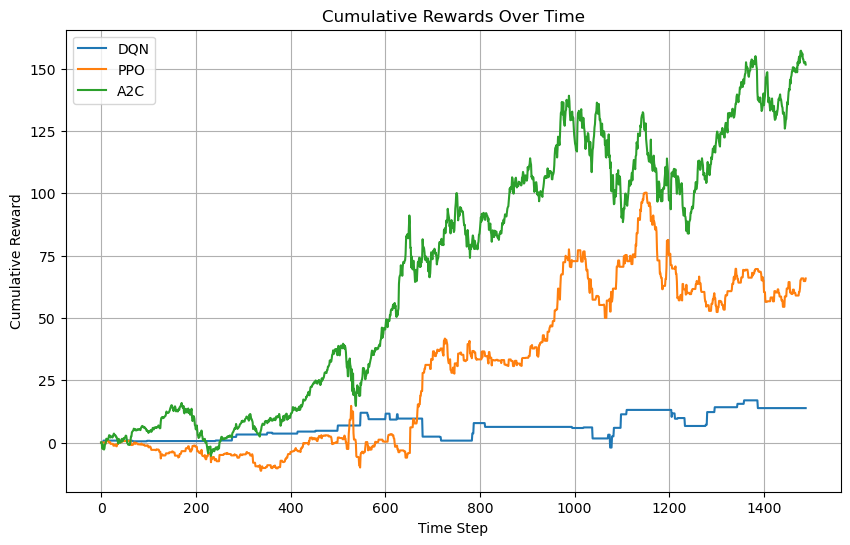

DQN Total Reward: 13.85
PPO Total Reward: 65.85
A2C Total Reward: 151.67


In [9]:
plt.figure(figsize=(10,6))
plt.plot(rewards_dqn, label='DQN')
plt.plot(rewards_ppo, label='PPO')
plt.plot(rewards_a2c, label='A2C')
plt.title("Cumulative Rewards Over Time")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()

print(f"DQN Total Reward: {total_dqn:.2f}")
print(f"PPO Total Reward: {total_ppo:.2f}")
print(f"A2C Total Reward: {total_a2c:.2f}")